In [20]:
import praw
import nltk
import pandas as pd
import numpy as np
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split


***Load models***

In [21]:
# NLTK resources for noise reduction
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Load the pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = TFBertForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Load the pre-trained RoBERTa model
roberta_tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
roberta_model = TFRobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wuhofeijeffrey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wuhofeijeffrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/wuhofeijeffrey/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnl

***Set up Reddit API with PRAW***

In [22]:
reddit = praw.Reddit(
    username="fyp24075",
    password="xyZtor-puzgu2-jimfif",
    client_id="FHEWKhsWocLDbEZUvGOTdw",
    client_secret="211TdovfNPAnQdGfchGeW0waKfOjbg",
    user_agent="fyp24075"
)

***Fetch data from Reddit, and perform sentiment analysis with the pre-trained BERT model***

In [23]:
# Collect Reddit data
def collect_reddit_data(keyword, limit=100):
    posts = []
    for submission in reddit.subreddit("all").search(keyword, limit=limit):
        posts.append({
            "title": submission.title,
            "body": submission.selftext,
            "num_comments": submission.num_comments,
            "url": submission.url,
            "date": pd.to_datetime(submission.created_utc, unit='s').date()
        })
    return posts

# Noise reduction
def clean_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(cleaned_tokens)

# Classify sentiments
def classify_sentiment(score):
    if score < -0.1:
        return 'Negative'
    elif score > 0.1:
        return 'Positive'
    else:
        return 'Neutral'

# Sentiment analysis using BERT model
def analyze_sentiment_bert(df):
    for index, row in df.iterrows():
        cleaned_data = row['cleaned_data']

        if cleaned_data.strip():
            # Analysis with BERT model
            inputs = tokenizer(cleaned_data, return_tensors="tf", max_length=512, truncation=True, padding=True)
            outputs = model(inputs)
            
            # Calculate the sentiment score in the range of -1 to 1
            probabilities = tf.nn.softmax(outputs.logits, axis=1).numpy()[0]
            sentiment_score = sum(prob * (i - 2) for i, prob in enumerate(probabilities))
            sentiment_score /= 2  # Normalize to -1 to 1
            
            # Classify sentiment
            sentiment_label = classify_sentiment(sentiment_score)

            df.at[index, 'sentiment_score'] = sentiment_score
            df.at[index, 'predicted_sentiment'] = sentiment_label
        
        else:
            df.at[index, 'predicted_sentiment'] = None
            df.at[index, 'sentiment_score'] = None

def evaluate_performance(true_labels, predicted_labels):
    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Print the evaluation metrics
    print(f"Model Accuracy: {accuracy:.4f}")
    print(f"Model Precision: {precision:.4f}")
    print(f"Model Recall: {recall:.4f}")
    print(f"Model F1 Score: {f1:.4f}")


keywords = "iphone 14"  # set by user
limit = 300            # set by user

print(f"Input = {keywords}")
print()
print("Collecting Reddit data...")
reddit_data = collect_reddit_data(keywords, limit)
print(f"Collected {len(reddit_data)} Reddit posts")

# Data cleaning
print()
print("Cleaning Reddit data...")
df = pd.DataFrame(reddit_data)

# Combine title and body
# Clean data and create cleaned_data column
df['combined_text'] = df['title'] + " " + df['body'] 
cleaned_data_list = []
for each_post_text in df['combined_text']:
    cleaned_data_list.append(clean_text(each_post_text))
df['cleaned_data'] = cleaned_data_list

print()
print("Performing sentiment analysis with BERT model...")
analyze_sentiment_bert(df)
display(df.head(10))

print()
print(f"The overall sentiment score: {df['sentiment_score'].mean()}")
print(f"The overall sentiment classified: {classify_sentiment(df['sentiment_score'].mean())}")
    

Input = iphone 14

Collected 234 Reddit posts

Cleaning Reddit data...

Performing sentiment analysis with BERT model...


,title,body,num_comments,url,date,combined_text,cleaned_data,sentiment_score,predicted_sentiment
0,iphone 14 vs 13 difference,,669,https://i.redd.it/5rzt2uyggg4c1.jpg,2023-12-05,iphone 14 vs 13 difference,iphone vs difference,0.393973,Positive
1,People who own the iPhone 14 series. How is it...,Whats your experience so far with the iPhone 1...,408,https://www.reddit.com/r/iphone/comments/1bfm4...,2024-03-15,People who own the iPhone 14 series. How is it...,people iphone series far whats experience far ...,0.501678,Positive
2,Is the iPhone 14 Plus worth buying now in 2024?,\nThe iPhone 14 plus is literally a big deal r...,96,https://i.redd.it/qc6rc9wekhqd1.jpeg,2024-09-23,Is the iPhone 14 Plus worth buying now in 2024...,iphone plus worth buying iphone plus literally...,0.164274,Positive
3,Is it worth it to buy iPhone 14 now?,,41,https://www.reddit.com/r/iphone14/comments/1fh...,2024-09-15,Is it worth it to buy iPhone 14 now?,worth buy iphone,0.729253,Positive
4,iphone 13 or 14 (help me decide),helloo! planning to purchase my 1st iphone eve...,27,https://www.reddit.com/r/Tech_Philippines/comm...,2024-09-11,iphone 13 or 14 (help me decide) helloo! plann...,iphone help decide helloo planning purchase ip...,-0.344420,Negative
5,iPhone 14 worth it still in 2024 ?,\nI saw someone selling iPhone 14 pro for almo...,43,https://www.reddit.com/r/iphone14/comments/1cp...,2024-05-11,iPhone 14 worth it still in 2024 ? \nI saw som...,iphone worth still saw someone selling iphone ...,-0.331285,Negative
6,Apple Intelligence on iPhone 14!,Looks like I got it just in time too. Rip to t...,62,https://i.redd.it/6jg4j8ecurqd1.jpeg,2024-09-24,Apple Intelligence on iPhone 14! Looks like I ...,apple intelligence iphone looks like got time ...,-0.192881,Negative
7,Just upgraded from an iPhone SE 2 to an iPhone...,So I saw a post on here a while ago raving abo...,54,https://www.reddit.com/r/iphone/comments/1dq9b...,2024-06-28,Just upgraded from an iPhone SE 2 to an iPhone...,upgraded iphone se iphone holy moly difference...,-0.362591,Negative
8,iPhone 14 in 2024,Just wanna ask if the iPhone 14 still worth in...,18,https://www.reddit.com/r/iphone14/comments/1cq...,2024-05-12,iPhone 14 in 2024 Just wanna ask if the iPhone...,iphone wan na ask iphone still worth im short ...,0.274194,Positive
9,Night Sky while camping @ Guadalupe Mountains ...,,1189,https://www.reddit.com/gallery/17ysoel,2023-11-19,Night Sky while camping @ Guadalupe Mountains ...,night sky camping guadalupe mountains national...,0.509415,Positive



The overall sentiment score: -0.008122405478070116
The overall sentiment classified: Neutral


***Train-test split on the labelled Ebay dataset, and evaluate BERT model***

In [24]:
# Load Ebay labelled and cleaned datasets
print()
print("Loading the cleaned Ebay review datasets...")
ebay_reviews_cleaned_df = pd.read_csv('ebay_reviews_cleaned.csv')
display(ebay_reviews_cleaned_df.head())

# Evaluate the BERT model
print()
print("Splitting the eBay review data into training and testing sets...")
ebay_train_df, ebay_test_df = train_test_split(ebay_reviews_cleaned_df, test_size=0.1, random_state=42, stratify=ebay_reviews_cleaned_df['sentiment'])
display(ebay_test_df.head())

print()
print("Performing sentiment analysis on the test data...")
analyze_sentiment_bert(ebay_test_df)
true_labels = ebay_test_df['sentiment']
predicted_labels = ebay_test_df['predicted_sentiment']  

# Call the evaluation function
print()
print("Evaluating performance of the BERT model...")
evaluate_performance(true_labels, predicted_labels)


Loading the cleaned Ebay review datasets...


,rating,cleaned_data,sentiment
0,1,wireless gaming headset gaming headset ticks ...,Positive
1,0,good big head low budget easy setup rated 6 ho...,Neutral
2,1,mezumiwireless gaming headset originally bough...,Positive
3,1,hw s2 great headset 2nd mezumi headset kills f...,Positive
4,1,best headphones ive purchased entire life prob...,Positive



Splitting the eBay review data into training and testing sets...


,rating,cleaned_data,sentiment
29851,1,wh1000xm4 great sound cancellation complex fu...,Positive
3148,-1,return would not work properly,Negative
8883,1,super verified purchase yes condition preown...,Positive
41334,1,well worth great sound great noise cancelling ...,Positive
8926,1,excellent unlocked phone phone very good condi...,Positive



Performing sentiment analysis on the test data...

Evaluating performance of the BERT model...
Model Accuracy: 0.8689
Model Precision: 0.9303
Model Recall: 0.8689
Model F1 Score: 0.8906


***Evaluate the performance of RoBERTa model on labelled eBay data***

In [25]:
def analyze_sentiment_roberta(df):
    for index, row in df.iterrows():
        cleaned_data = row['cleaned_data']

        if cleaned_data.strip():
            # Analysis with RoBERTa model
            inputs = roberta_tokenizer(cleaned_data, return_tensors="tf", max_length=512, truncation=True, padding=True)
            outputs = roberta_model(inputs)
            
            # Calculate the sentiment score in the range of -1 to 1
            probabilities = tf.nn.softmax(outputs.logits, axis=1).numpy()[0]
            
            # Adjusting the probabilities for sentiment score calculation (Index 0: Negative, 1: Neutral, 2: Positive)
            sentiment_score = sum(prob * (i - 1) for i, prob in enumerate(probabilities))  # Maps to -1 to 1

            # Classify sentiment based on the adjusted score
            sentiment_label = classify_sentiment(sentiment_score)

            df.at[index, 'sentiment_score'] = sentiment_score  # Adjust score to be -1 to 1
            df.at[index, 'predicted_sentiment'] = sentiment_label
        
        else:
            df.at[index, 'predicted_sentiment'] = None
            df.at[index, 'sentiment_score'] = None


print()
print("Performing sentiment analysis on the eBay test data with RoBERTa model...")
analyze_sentiment_roberta(ebay_test_df)
true_labels = ebay_test_df['sentiment']
predicted_labels = ebay_test_df['predicted_sentiment']

print()
print("Evaluating performance of the RoBERTa model...")
evaluate_performance(true_labels, predicted_labels)



Performing sentiment analysis on the eBay test data with RoBERTa model...

Evaluating performance of the RoBERTa model...
Model Accuracy: 0.9104
Model Precision: 0.9291
Model Recall: 0.9104
Model F1 Score: 0.9176


***Sentiment Analysis on Reddit data with RoBERTa model***


Performing sentiment analysis with RoBERTa model...


,title,body,num_comments,url,date,combined_text,cleaned_data,sentiment_score,predicted_sentiment
0,iphone 14 vs 13 difference,,669,https://i.redd.it/5rzt2uyggg4c1.jpg,2023-12-05,iphone 14 vs 13 difference,iphone vs difference,-0.015957,Neutral
1,People who own the iPhone 14 series. How is it...,Whats your experience so far with the iPhone 1...,408,https://www.reddit.com/r/iphone/comments/1bfm4...,2024-03-15,People who own the iPhone 14 series. How is it...,people iphone series far whats experience far ...,0.358235,Positive
2,Is the iPhone 14 Plus worth buying now in 2024?,\nThe iPhone 14 plus is literally a big deal r...,96,https://i.redd.it/qc6rc9wekhqd1.jpeg,2024-09-23,Is the iPhone 14 Plus worth buying now in 2024...,iphone plus worth buying iphone plus literally...,0.954404,Positive
3,Is it worth it to buy iPhone 14 now?,,41,https://www.reddit.com/r/iphone14/comments/1fh...,2024-09-15,Is it worth it to buy iPhone 14 now?,worth buy iphone,0.335729,Positive
4,iphone 13 or 14 (help me decide),helloo! planning to purchase my 1st iphone eve...,27,https://www.reddit.com/r/Tech_Philippines/comm...,2024-09-11,iphone 13 or 14 (help me decide) helloo! plann...,iphone help decide helloo planning purchase ip...,0.533670,Positive
5,iPhone 14 worth it still in 2024 ?,\nI saw someone selling iPhone 14 pro for almo...,43,https://www.reddit.com/r/iphone14/comments/1cp...,2024-05-11,iPhone 14 worth it still in 2024 ? \nI saw som...,iphone worth still saw someone selling iphone ...,0.603227,Positive
6,Apple Intelligence on iPhone 14!,Looks like I got it just in time too. Rip to t...,62,https://i.redd.it/6jg4j8ecurqd1.jpeg,2024-09-24,Apple Intelligence on iPhone 14! Looks like I ...,apple intelligence iphone looks like got time ...,0.192417,Positive
7,Just upgraded from an iPhone SE 2 to an iPhone...,So I saw a post on here a while ago raving abo...,54,https://www.reddit.com/r/iphone/comments/1dq9b...,2024-06-28,Just upgraded from an iPhone SE 2 to an iPhone...,upgraded iphone se iphone holy moly difference...,0.715719,Positive
8,iPhone 14 in 2024,Just wanna ask if the iPhone 14 still worth in...,18,https://www.reddit.com/r/iphone14/comments/1cq...,2024-05-12,iPhone 14 in 2024 Just wanna ask if the iPhone...,iphone wan na ask iphone still worth im short ...,0.051300,Neutral
9,Night Sky while camping @ Guadalupe Mountains ...,,1189,https://www.reddit.com/gallery/17ysoel,2023-11-19,Night Sky while camping @ Guadalupe Mountains ...,night sky camping guadalupe mountains national...,0.275535,Positive



The overall sentiment score: 0.21278957550316396
The overall sentiment classified: Positive

Plotting sentiment scores over time...


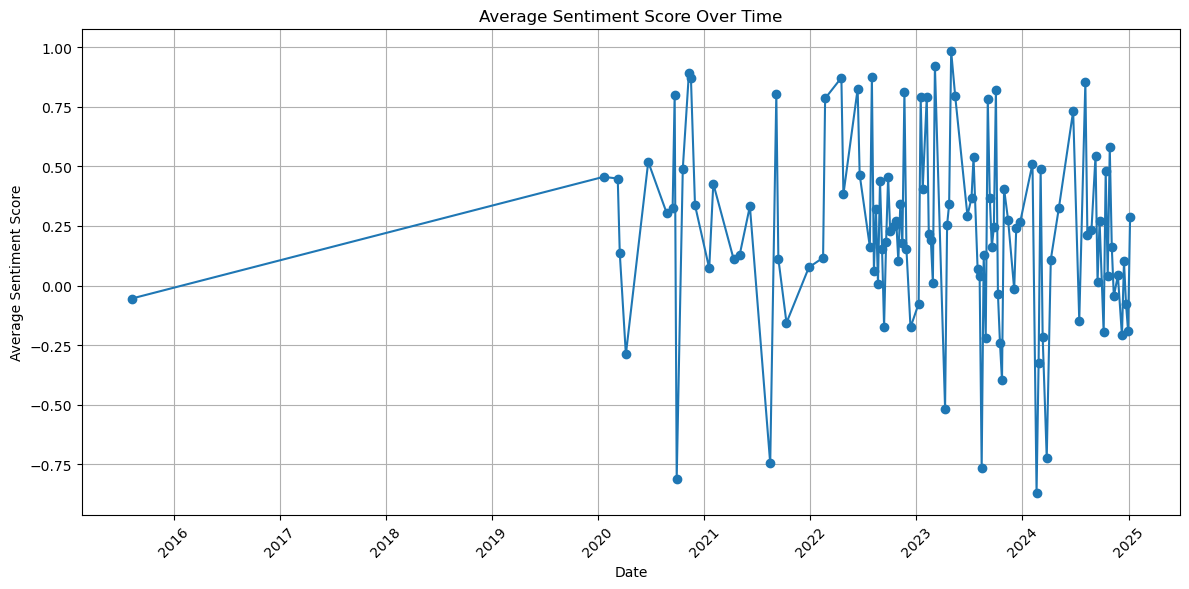

In [27]:
print()
print("Performing sentiment analysis with RoBERTa model...")
analyze_sentiment_roberta(df)
display(df.head(10))

print()
print(f"The overall sentiment score: {df['sentiment_score'].mean()}")
print(f"The overall sentiment classified: {classify_sentiment(df['sentiment_score'].mean())}")

def plot_sentiment_over_time(df):
    # Create a new column for grouping by week
    df['date_by_week'] = pd.to_datetime(df['date']).dt.to_period('W').apply(lambda r: r.start_time)

    # Group by the new 'date_by_week' column and calculate average sentiment score
    sentiment_over_time = df.groupby('date_by_week')['sentiment_score'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(sentiment_over_time['date_by_week'], sentiment_over_time['sentiment_score'], marker='o', linestyle='-')
    plt.title('Average Sentiment Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()
    
# Plot sentiment scores over time
print()
print("Plotting sentiment scores over time...")
plot_sentiment_over_time(df)